**Time Series Analysis - Project 2: Random Forest**

**Model Accuracy: 96.05% (non-rolling), 92. 65% (rollling)** <br>
**In this project we will be predicting sales data using the Random Forest regression model** <br>
**The dataset can be found here: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/catfish.csv**

**Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**Importing the dataset**

In [2]:
df = pd.read_csv("/Users/willbarnard/Downloads/catfish.csv", parse_dates=[0], index_col=[0], date_format = '%Y-%m-%d')
df = df.asfreq(pd.infer_freq(df.index))

start_date = datetime(1986, 1, 1)
end_date = datetime(2004, 1, 1)
lim_df = df[start_date:end_date]

In [3]:
lim_df.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


**Checking for erroneous data entries**

In [4]:
print("Missing values:\n", lim_df.isnull().sum())

Missing values:
 Total    0
dtype: int64


**Displaying dataset statistical metrics (EDA)**

In [5]:
print("Dataset Summary:\n", lim_df.describe())

Dataset Summary:
               Total
count    217.000000
mean   19392.400922
std     5253.746842
min     8196.000000
25%    15486.000000
50%    19500.000000
75%    23576.000000
max    30485.000000


**Displaying the total dataset**

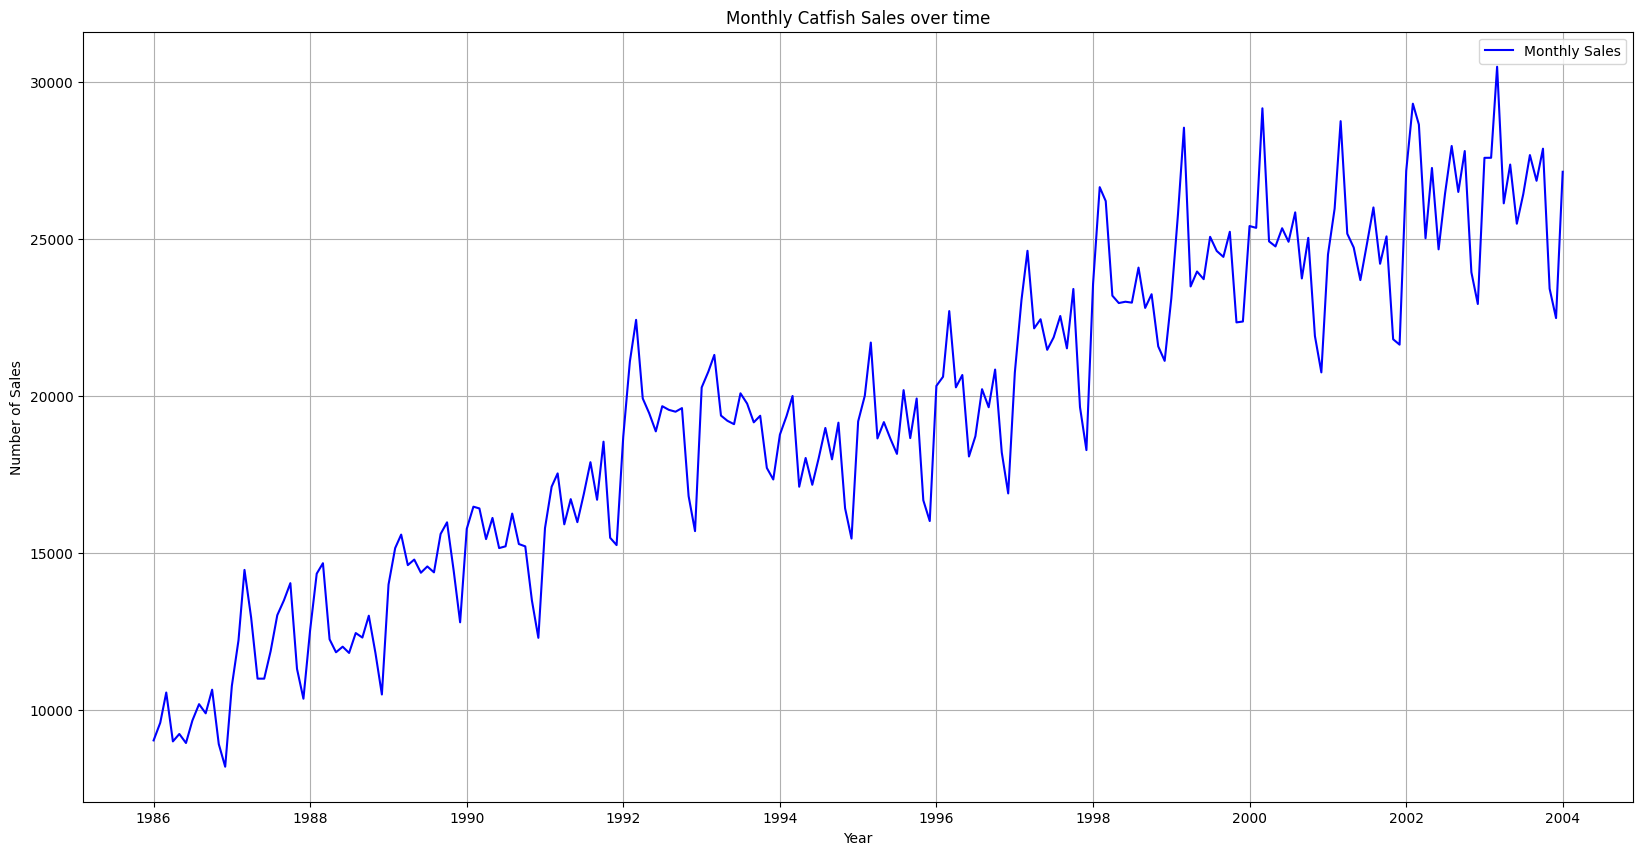

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(lim_df.index, lim_df["Total"], label="Monthly Sales", color="blue")
plt.xlabel("Year")
plt.ylabel("Number of Sales")
plt.title("Monthly Catfish Sales over time")
plt.legend()
plt.grid()
plt.show()

**Cross-Correlation Analysis**

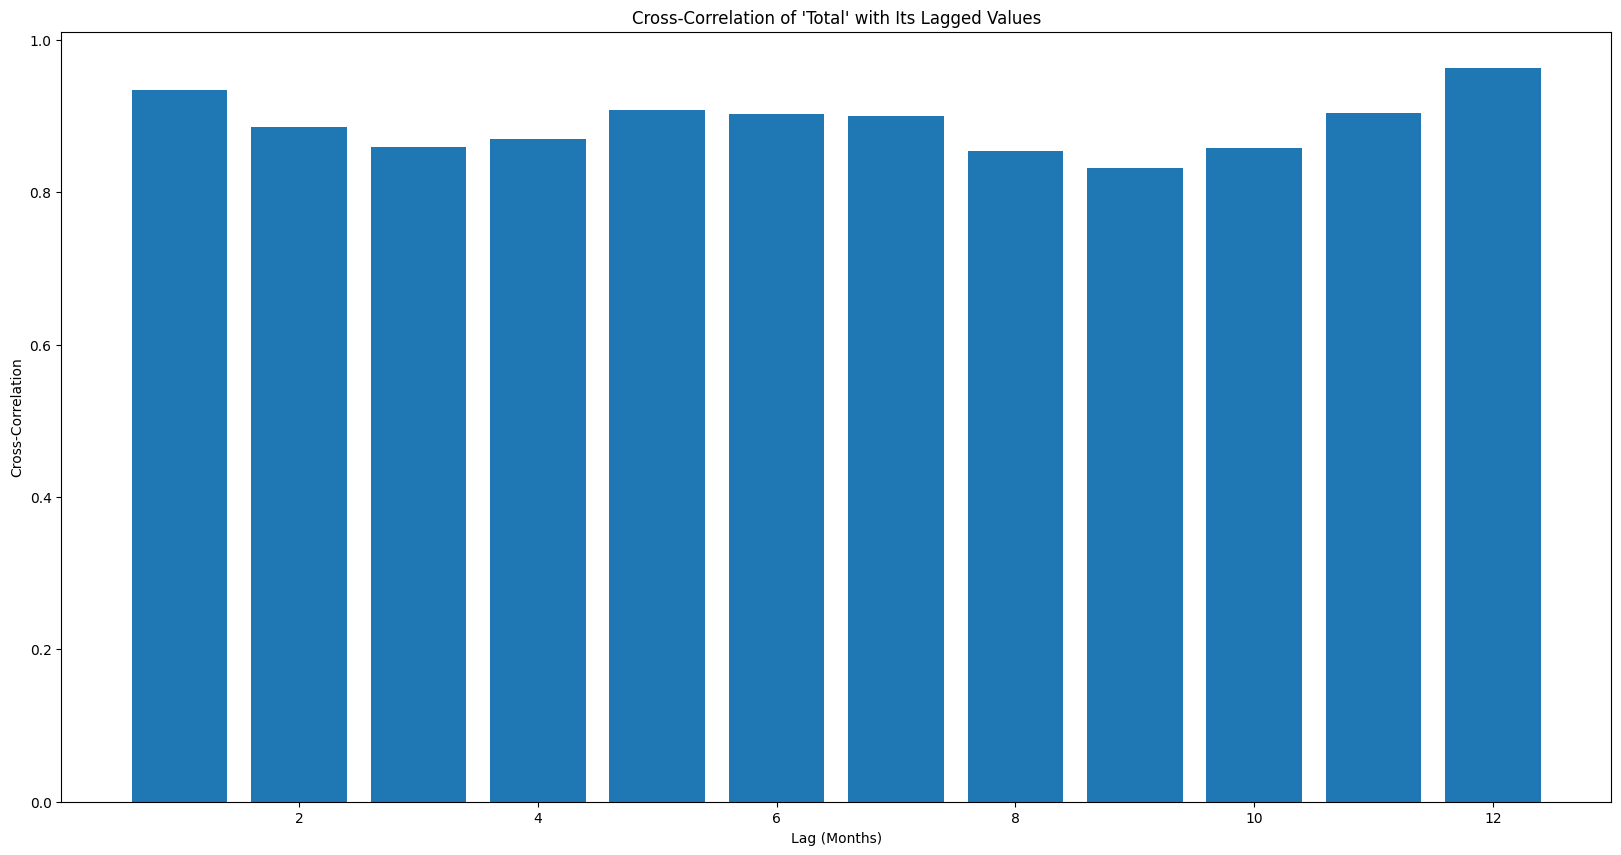

In [7]:

lags = np.arange(1, 12 + 1)  
correlations = [lim_df['Total'].corr(lim_df['Total'].shift(lag)) for lag in lags]

plt.figure(figsize=(20, 10))
plt.bar(lags, correlations)
plt.xlabel("Lag (Months)")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlation of 'Total' with Its Lagged Values")
plt.show()

**Selecting significant lags**

In [8]:

significant_lags = [lag for lag, corr in zip(lags, correlations) if abs(corr) > 0.3]
print("Significant Lags:", significant_lags)


Significant Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


**Performing feature engineering on the dataset**

In [9]:
df_features = lim_df.copy()
    
for i in range(1, 12 + 1):
    df_features[f"Lag_{i}"] = df_features["Total"].shift(i)
    df_features["Year"] = df_features.index.year
    df_features["Month"] = df_features.index.month
    df_features["Quarter"] = df_features.index.quarter

    df_features["Rolling_3"] = df_features["Total"].rolling(window=3).mean()  
    df_features["Rolling_6"] = df_features["Total"].rolling(window=6).mean() 
    df_features["Rolling_12"] = df_features["Total"].rolling(window=12).mean()


df_features = df_features.dropna()





df_features.head()

,Total,Lag_1,Year,Month,Quarter,Rolling_3,Rolling_6,Rolling_12,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12
Date,,,,,,,,,,,,,,,,,,,
1987-01-01,10768,8196.0,1987,1,1,9293.666667,9769.000000,9635.666667,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0,9596.0,9034.0
1987-02-01,12220,10768.0,1987,2,1,10394.666667,10107.666667,9854.333333,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0,9596.0
1987-03-01,14463,12220.0,1987,3,1,12483.666667,10868.833333,10179.750000,10768.0,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0,10558.0
1987-04-01,12944,14463.0,1987,4,2,13209.000000,11251.333333,10508.250000,12220.0,10768.0,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0,9002.0
1987-05-01,11001,12944.0,1987,5,2,12802.666667,11598.666667,10655.083333,14463.0,12220.0,10768.0,8196.0,8917.0,10649.0,9896.0,10188.0,9668.0,8951.0,9239.0


**Splitting the dataset into testing and training**

In [10]:
X = df_features.drop(columns=["Total"])
y = df_features["Total"]

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training size: {len(X_train)}, Testing size: {len(X_test)}")

Training size: 164, Testing size: 41


**Hyperparameter tuning using grid search**

In [11]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


**Defining the random forest model**

In [12]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

**Calculating predictions**

In [13]:
y_pred = rf.predict(X_test)

**Error metric: MAPE**

In [14]:
residuals = y_test - y_pred
residuals
print('Mean Absolute Percent error: ', round(np.mean(abs(residuals/y_test)), 4))

Mean Absolute Percent error:  0.0389


**Other error metrics**

In [15]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" Model Performance Metrics:")
print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" R² Score: {r2:.2f}")

 Model Performance Metrics:
 Mean Absolute Error (MAE): 987.41
 Root Mean Squared Error (RMSE): 1243.09
 R² Score: 0.69


**Displaying predictions**

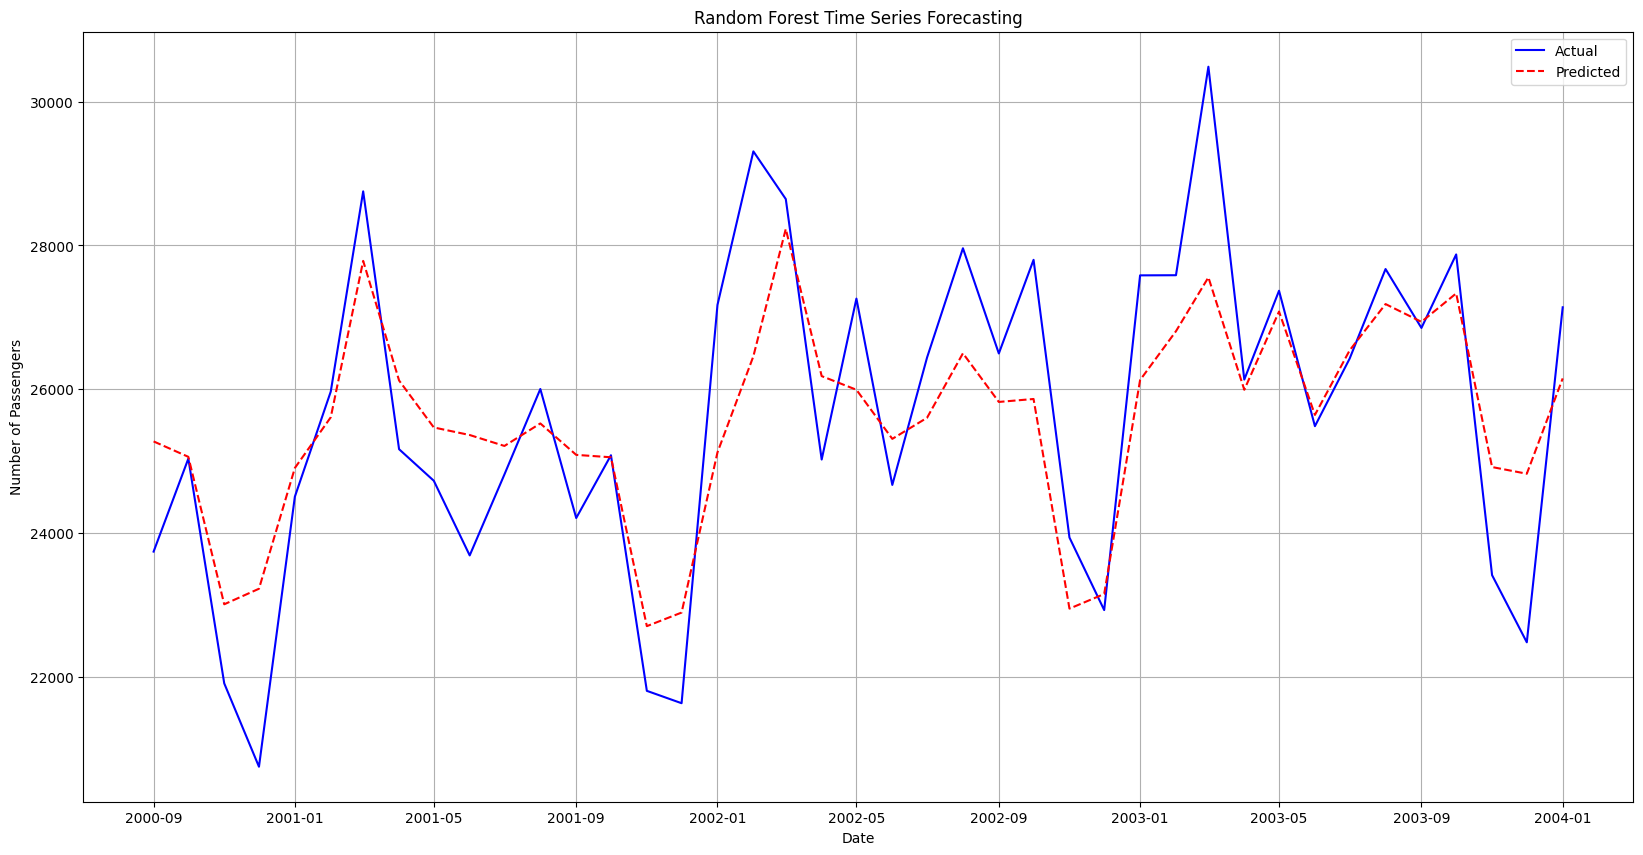

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Random Forest Time Series Forecasting")
plt.legend()
plt.grid()
plt.show()

**Displaying total dataset**

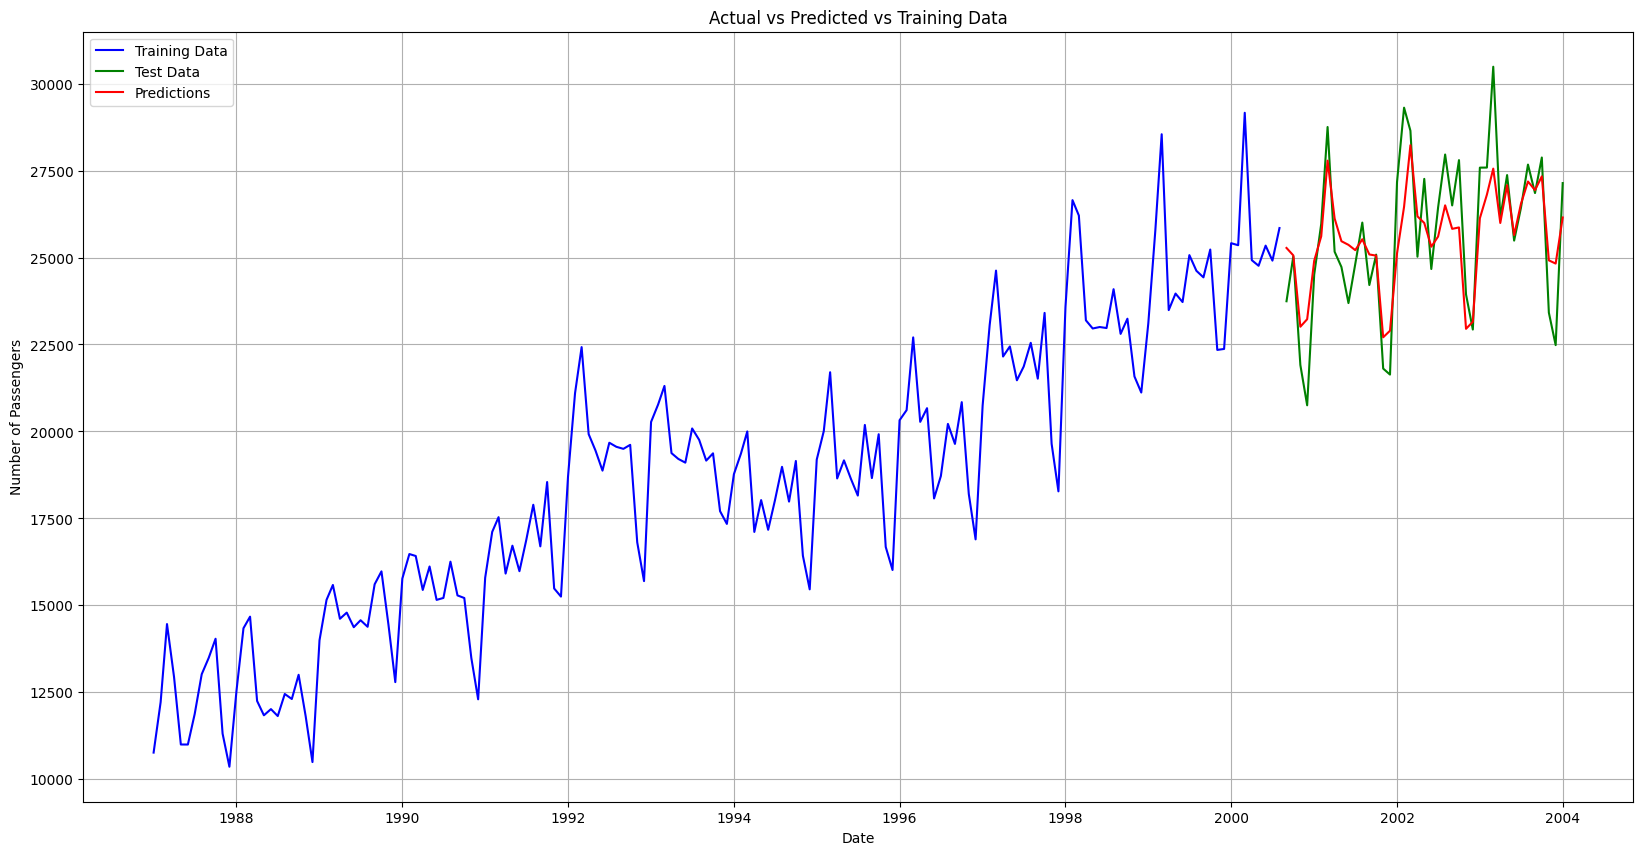

In [17]:
plt.figure(figsize=(20, 10))

plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Test Data", color="green")
plt.plot(y_test.index, y_pred, label="Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Actual vs Predicted vs Training Data")
plt.legend()

plt.grid(True)
plt.show()


**Calculating rolling predictions**

In [18]:
forecast = []
history_X = X_train.copy()
history_y = y_train.copy()

for t in range(len(X_test)):
    X_input = history_X.iloc[-1:].values  
    y_pred = rf.predict(X_input)[0]
    forecast.append(y_pred)

  
    new_row_X = X_test.iloc[t:t+1].copy()
    new_row_X["Lag_1"] = y_pred 
    history_X = pd.concat([history_X, new_row_X]).iloc[1:]  
    history_y = pd.concat([history_y, pd.Series([y_pred], index=[X_test.index[t]])])


y_rolling_pred = np.array(forecast)

/Users/willbarnard/tf-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/willbarnard/tf-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/willbarnard/tf-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/willbarnard/tf-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/willbarnard/tf-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomFor

**Error metric: MAPE**

In [19]:
residuals = y_test - y_rolling_pred
residuals
print('Mean Absolute Percent error: ', round(np.mean(abs(residuals/y_test)), 4))

Mean Absolute Percent error:  0.0712


**Other error metrics**

In [20]:
mae = mean_absolute_error(y_test, y_rolling_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_rolling_pred))
r2 = r2_score(y_test, y_rolling_pred)

print(f" Model Performance Metrics:")
print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" R² Score: {r2:.2f}")

 Model Performance Metrics:
 Mean Absolute Error (MAE): 1822.46
 Root Mean Squared Error (RMSE): 2180.73
 R² Score: 0.05


**Displaying rolling predictions**

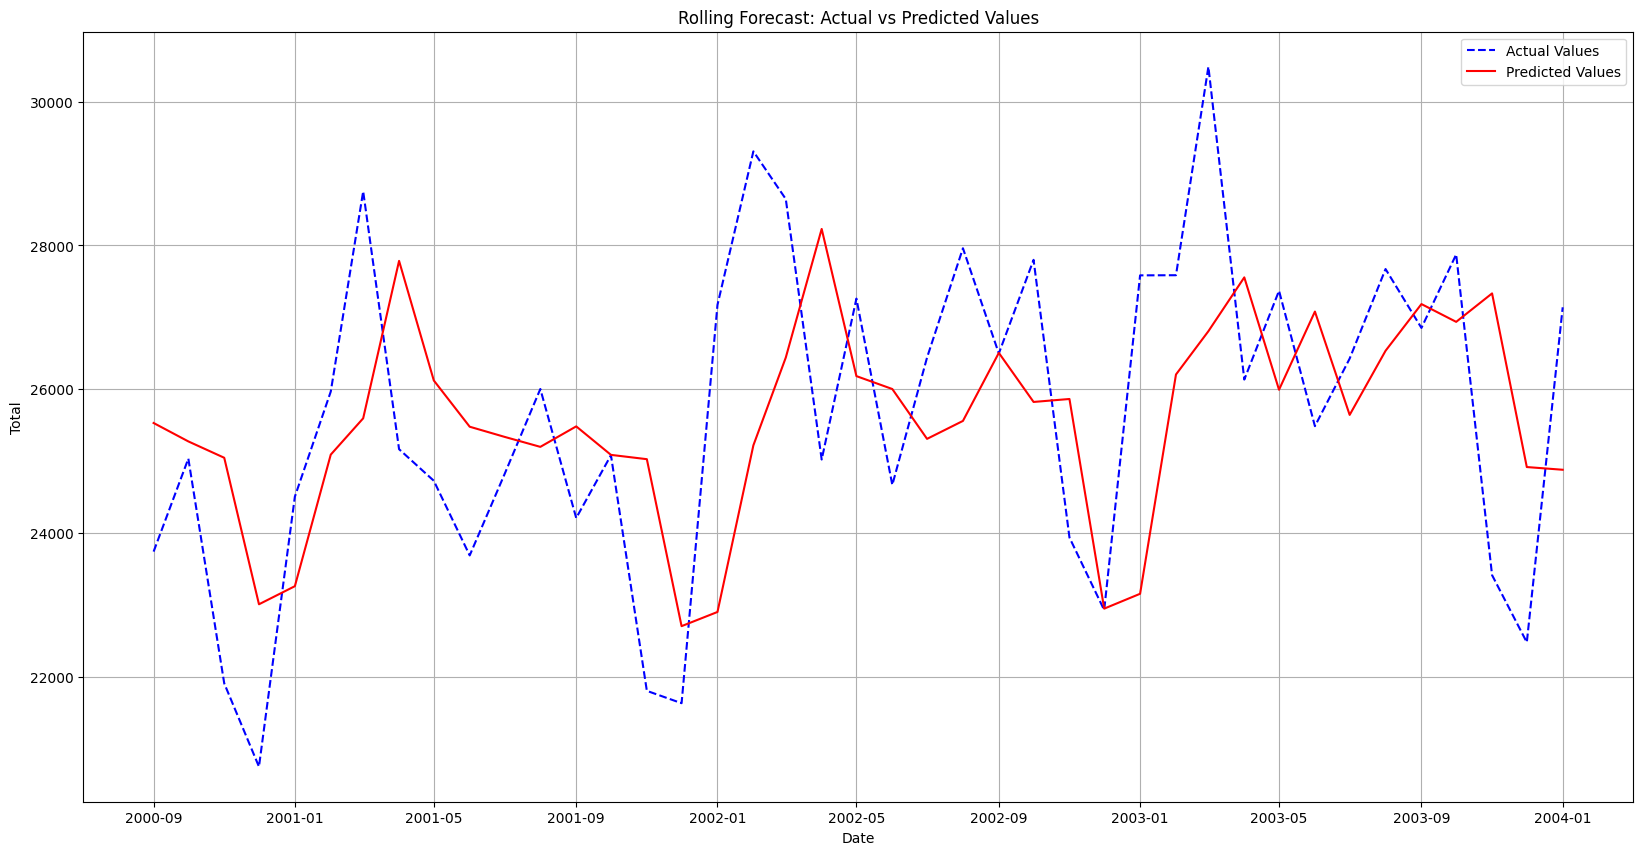

In [21]:
plt.figure(figsize=(20, 10))

plt.plot(y_test.index, y_test.values, label='Actual Values', color='blue', linestyle='--')
plt.plot(y_test.index, y_rolling_pred, label='Predicted Values', color='red', linestyle='-')

plt.title('Rolling Forecast: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()

plt.grid(True)
plt.show()

**Displaying total dataset**

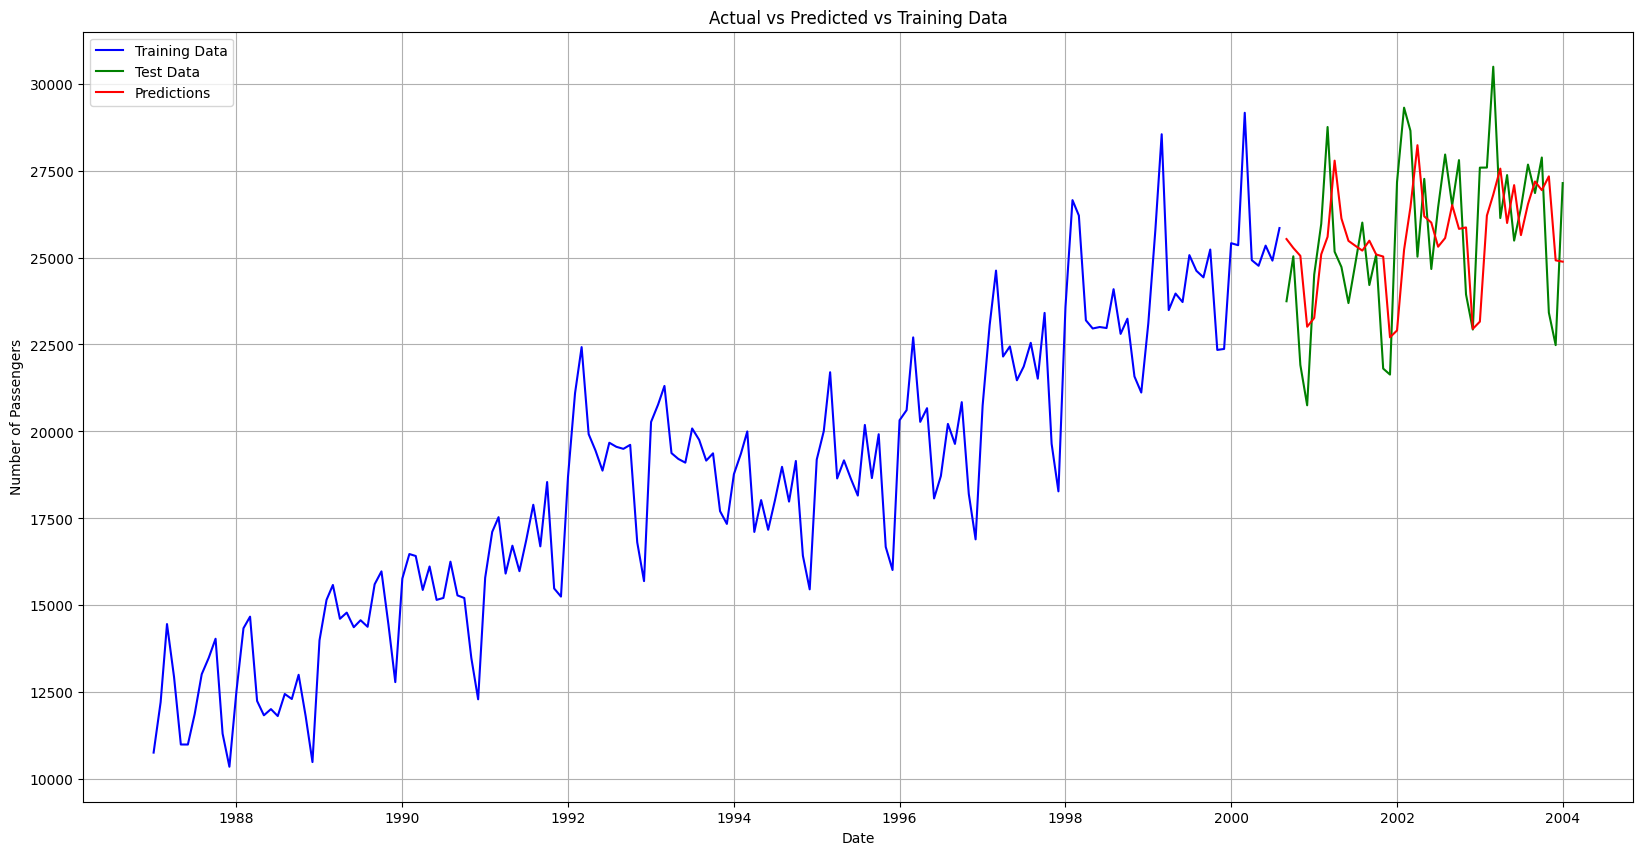

In [22]:
plt.figure(figsize=(20, 10))

plt.plot(y_train.index, y_train, label="Training Data", color="blue")
plt.plot(y_test.index, y_test, label="Test Data", color="green")
plt.plot(y_test.index, y_rolling_pred, label="Predictions", color="red")

plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Actual vs Predicted vs Training Data")
plt.legend()

plt.grid(True)
plt.show()

**Model interpretation: Feature importance**

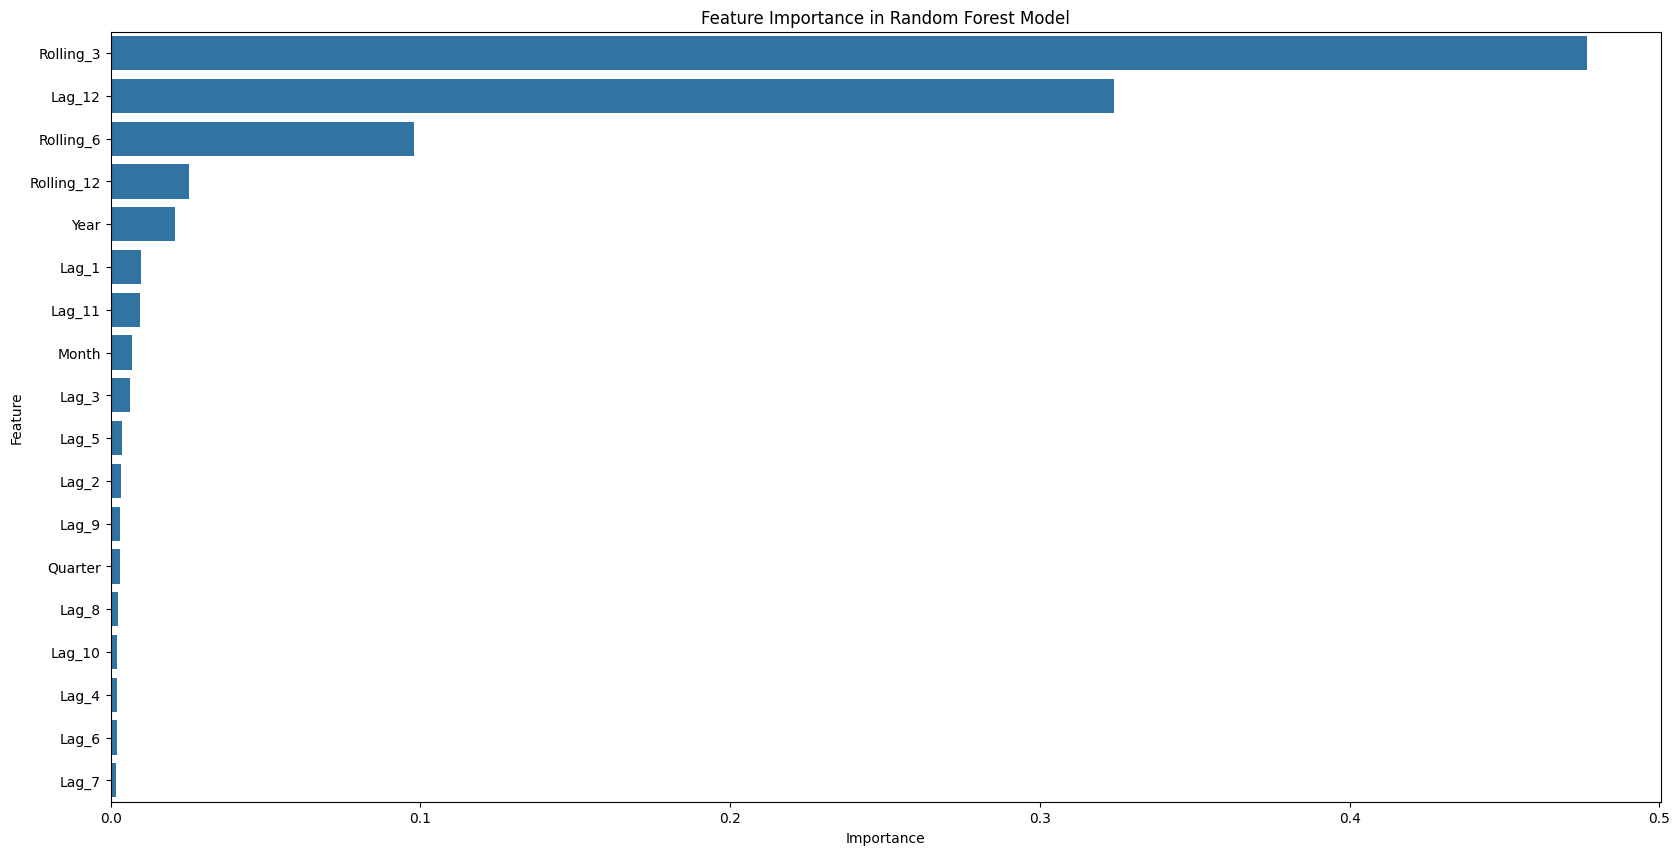

In [24]:
feature_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Feature Importance in Random Forest Model")
plt.show()